In [4]:
install.packages(c("ggplot2", "stringr", "plyr", "dplyr", "lubridate", "reshape2", "scales", "ggthemes", "Metrics"))

Installing packages into 'C:/Users/jeanh/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)

also installing the dependencies 'stringi', 'Rcpp'




package 'stringi' successfully unpacked and MD5 sums checked
package 'Rcpp' successfully unpacked and MD5 sums checked
package 'ggplot2' successfully unpacked and MD5 sums checked
package 'stringr' successfully unpacked and MD5 sums checked
package 'plyr' successfully unpacked and MD5 sums checked
package 'dplyr' successfully unpacked and MD5 sums checked
package 'lubridate' successfully unpacked and MD5 sums checked
package 'reshape2' successfully unpacked and MD5 sums checked
package 'scales' successfully unpacked and MD5 sums checked
package 'ggthemes' successfully unpacked and MD5 sums checked
package 'Metrics' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\jeanh\AppData\Local\Temp\RtmpcHcmC8\downloaded_packages


In [5]:
library(ggplot2)
library(stringr)
library(plyr)
library(dplyr)
library(lubridate)
library(reshape2)
library(scales)
library(ggthemes)
library(Metrics)


Attaching package: 'dplyr'


The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




In [25]:
data <- read.csv("r2plus1d_18_32_2_pretrained_test_predictions.csv", header = FALSE)
str(data)

'data.frame':	147271 obs. of  3 variables:
 $ V1: chr  "0X100CF05D141FF143.avi" "0X100CF05D141FF143.avi" "0X100CF05D141FF143.avi" "0X100CF05D141FF143.avi" ...
 $ V2: int  0 1 2 3 4 5 6 7 8 9 ...
 $ V3: num  60.5 60.6 60.4 60.7 61 ...


In [26]:
# 筛选出 V2 值等于 0 的所有行（即所有测试集视频的第0帧），并将结果存储在 dataNoAugmentation 中
dataNoAugmentation <- data[data$V2 == 0,]
str(dataNoAugmentation)

'data.frame':	1276 obs. of  3 variables:
 $ V1: chr  "0X100CF05D141FF143.avi" "0X1012703CDC1436FE.avi" "0X102CFB07F752AAE6.avi" "0X105B9EF57DE45DCB.avi" ...
 $ V2: int  0 0 0 0 0 0 0 0 0 0 ...
 $ V3: num  60.5 47 56.6 54.5 60.9 ...


In [10]:
# 根据视频文件名（V1）进行分组，计算每个视频中所有帧的预测射血分数的平均值（meanPrediction）和标准差（sdPred）
dataGlobalAugmentation <- data %>% group_by(V1) %>% summarize(meanPrediction = mean(V3), sdPred = sd(V3))
str(dataGlobalAugmentation)

tibble [1,276 × 3] (S3: tbl_df/tbl/data.frame)
 $ V1            : chr [1:1276] "0X100CF05D141FF143.avi" "0X1012703CDC1436FE.avi" "0X102CFB07F752AAE6.avi" "0X105B9EF57DE45DCB.avi" ...
 $ meanPrediction: num [1:1276] 61.1 45.1 50 53.2 61.2 ...
 $ sdPred        : num [1:1276] 0.671 2.486 4.065 1.888 1.093 ...


In [11]:
# 找出模型预测该帧为 "小" 的目标，也就是模型认为这是一个收缩期的帧
sizeData <- read.csv("size.csv")
sizeData <- sizeData[sizeData$ComputerSmall == 1,]
str(sizeData)

'data.frame':	5024 obs. of  6 variables:
 $ Filename     : chr  "0X100CF05D141FF143.avi" "0X100CF05D141FF143.avi" "0X100CF05D141FF143.avi" "0X100CF05D141FF143.avi" ...
 $ Frame        : int  23 89 150 213 23 71 122 174 30 85 ...
 $ Size         : int  858 794 830 823 1706 1670 1670 1689 866 573 ...
 $ HumanLarge   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ HumanSmall   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ComputerSmall: int  1 1 1 1 1 1 1 1 1 1 ...


In [12]:
sizeRelevantFrames <- sizeData[c(1,2)] # 选择 sizeData 的第 1 和第 2 列，R语言的index是从1开始的
sizeRelevantFrames$Frame <- sizeRelevantFrames$Frame - 32 # 将 sizeRelevantFrames 中 Frame 列的每个值减去 32
sizeRelevantFrames[sizeRelevantFrames$Frame < 0,]$Frame <- 0 # 将所有 Frame 值小于 0 的行的 Frame 值重置为 0

In [42]:
beatByBeat <- merge(sizeRelevantFrames, data, by.x = c("Filename", "Frame"), by.y = c("V1", "V2")) # 将 sizeRelevantFrames 和 data 两个数据框合并，合并后，得到的数据框 beatByBeat 将包含 sizeRelevantFrames 和 data 中匹配的行
beatByBeat <- beatByBeat %>% group_by(Filename) %>% summarize(meanPrediction = mean(V3), sdPred = sd(V3)) # 对 beatByBeat 数据按 Filename 进行分组
str(beatByBeat)

tibble [1,274 × 3] (S3: tbl_df/tbl/data.frame)
 $ Filename      : chr [1:1274] "0X100CF05D141FF143.avi" "0X1012703CDC1436FE.avi" "0X102CFB07F752AAE6.avi" "0X105B9EF57DE45DCB.avi" ...
 $ meanPrediction: num [1:1274] 61 45.5 51.8 54.3 60.9 ...
 $ sdPred        : num [1:1274] 0.6066 1.4462 4.1208 1.3585 0.0306 ...


In [17]:
fileLocation <- "E:/Ultrasound/EchoNet-Dynamic/dynamic-master-gpu/a4c-video-dir/"
ActualNumbers <- read.csv(paste0(fileLocation, "FileList.csv", sep = ""))
ActualNumbers <- ActualNumbers[c(1,2)]
str(ActualNumbers)

'data.frame':	10030 obs. of  2 variables:
 $ FileName: num  1.15e+18 1.15e+18 1.15e+18 1.15e+18 1.16e+18 ...
 $ EF      : num  78.5 59.1 62.4 54.5 24.9 ...


In [27]:
dataNoAugmentation$V1 <- as.numeric(gsub("\\.avi$", "", dataNoAugmentation$V1)) # 去掉 .avi 后缀，并将 V1 列转换为数值类型

In [28]:
dataNoAugmentation <- merge(dataNoAugmentation, ActualNumbers, by.x = "V1", by.y = "FileName", all.x = TRUE)
dataNoAugmentation$AbsErr <- abs(dataNoAugmentation$V3 - dataNoAugmentation$EF)
str(dataNoAugmentation)

'data.frame':	1276 obs. of  5 variables:
 $ V1    : num  7.29e+15 1.85e+16 3.15e+16 4.26e+16 8.39e+16 ...
 $ V2    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ V3    : num  66.4 62.7 54.2 64 59.4 ...
 $ EF    : num  66 58.3 56.9 60.2 58.5 ...
 $ AbsErr: num  0.353 4.408 2.719 3.802 0.916 ...


In [29]:
summary(abs(dataNoAugmentation$V3 - dataNoAugmentation$EF))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.01173  1.50524  3.18150  4.18681  5.71472 28.37943 

In [30]:
rmse(dataNoAugmentation$V3,dataNoAugmentation$EF) 

[1] 5.612154

In [31]:
modelNoAugmentation <- lm(dataNoAugmentation$EF ~ dataNoAugmentation$V3)
summary(modelNoAugmentation)$r.squared

[1] 0.7906585

In [43]:
beatByBeat$Filename <- as.numeric(gsub("\\.avi$", "", beatByBeat$Filename))
beatByBeat <- merge(beatByBeat, ActualNumbers, by.x = "Filename", by.y = "FileName", all.x = TRUE)
summary(abs(beatByBeat$meanPrediction - beatByBeat$EF))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000475  1.375960  3.132065  3.957903  5.393616 27.191628 

In [44]:
rmse(beatByBeat$meanPrediction, beatByBeat$EF) 
# 5.325237

[1] 5.313563

In [45]:
modelBeatByBeat <- lm(beatByBeat$EF ~ beatByBeat$meanPrediction)
summary(modelBeatByBeat)$r.squared
# 0.8093174

[1] 0.8109906

In [46]:
beatByBeatAnalysis <- merge(sizeRelevantFrames, data, by.x = c("Filename", "Frame"), by.y = c("V1", "V2"))
str(beatByBeatAnalysis)

'data.frame':	4127 obs. of  3 variables:
 $ Filename: chr  "0X100CF05D141FF143.avi" "0X100CF05D141FF143.avi" "0X100CF05D141FF143.avi" "0X100CF05D141FF143.avi" ...
 $ Frame   : num  0 118 181 57 0 39 90 0 105 53 ...
 $ V3      : num  60.5 61.5 60.5 61.6 47 ...


In [47]:
MAEdata <- data.frame(counter = 1:500)
MAEdata$sample <- -9999
MAEdata$error <- -9999

str(MAEdata)

'data.frame':	500 obs. of  3 variables:
 $ counter: int  1 2 3 4 5 6 7 8 9 10 ...
 $ sample : num  -9999 -9999 -9999 -9999 -9999 ...
 $ error  : num  -9999 -9999 -9999 -9999 -9999 ...


In [51]:
for (i in 1:500){
samplingBeat <-  sample_n(beatByBeatAnalysis %>% group_by(Filename), 1 + floor((i-1)/100), replace = TRUE) %>% group_by(Filename) %>% dplyr::summarize(meanPred = mean(V3))
samplingBeat$Filename <- as.numeric(gsub("\\.avi$", "", samplingBeat$Filename))
samplingBeat <- merge(samplingBeat, ActualNumbers, by.x = "Filename", by.y = "FileName", all.x = TRUE)
samplingBeat$error <- abs(samplingBeat$meanPred - samplingBeat$EF)
MAEdata$sample[i] <-  1 + floor((i-1)/100)
MAEdata$error[i] <- mean(samplingBeat$error )
}

In [52]:
str(MAEdata)

'data.frame':	500 obs. of  3 variables:
 $ counter: int  1 2 3 4 5 6 7 8 9 10 ...
 $ sample : num  1 1 1 1 1 1 1 1 1 1 ...
 $ error  : num  4.15 4.09 4.17 4.11 4.13 ...


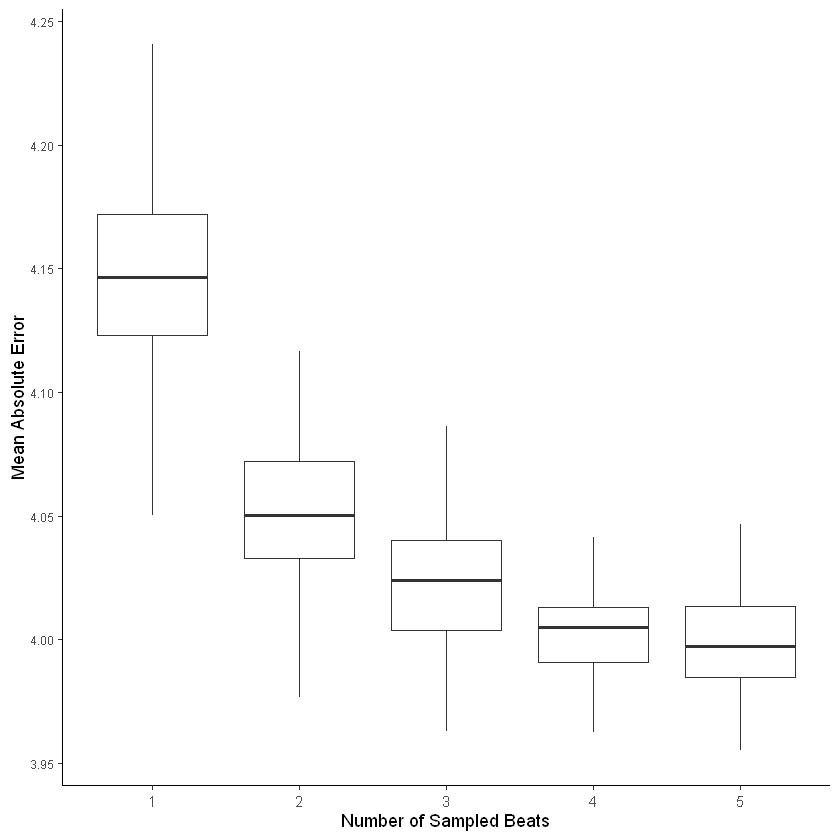

In [53]:
beatBoxPlot <- ggplot(data = MAEdata) + geom_boxplot(aes(x = sample, y = error, group = sample), outlier.shape = NA
) + theme_classic() + theme(legend.position = "none", axis.text.y = element_text( size=7)) + xlab("Number of Sampled Beats") + ylab("Mean Absolute Error") + scale_fill_brewer(palette = "Set1", direction = -1) 

beatBoxPlot